In [34]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Download data

In this section we will download the data and setup the paths.


In [35]:
os.makedirs('data', exist_ok=True)
if not os.path.exists('data/aerialseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/aerialseq.npy -O data/aerialseq.npy
if not os.path.exists('data/antseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/antseq.npy -O data/antseq.npy

# Q3: Affine Motion Subtraction

Asumming an affine warp function of the type

$$ W(x;p) =
\begin{bmatrix}
    1 + p_1 & p_2 \\
    p_4     & 1 + p_5
\end{bmatrix}\begin{bmatrix}
    x \\
    y
\end{bmatrix} +
\begin{bmatrix}
    p_3 \\
    p_6
\end{bmatrix} 



$$

## Q3.1: Dominant Motion Estimation (15 points)

In [36]:
from scipy.interpolate import RectBivariateSpline

def LucasKanadeAffine(It, It1, threshold, num_iters):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param num_iters : (int), number of iterations for running the optimization

    :return: M       : (2, 3) The affine transform matrix
    """
    def apply_affine_warp(pixels, warp_matrix, H,W):
        pixels = warp_matrix @ pixels
        return pixels[0].reshape(H,W), pixels[1].reshape(H,W)
    
    def build_jacobian(X, Y):
        X_flat = X.ravel()
        Y_flat = Y.ravel()

        ones = np.ones_like(X_flat)
        zeros = np.zeros_like(X_flat)
        J = np.stack([
            np.stack([X_flat, Y_flat, ones, zeros, zeros, zeros], axis=-1),
            np.stack([zeros, zeros, zeros, X_flat, Y_flat, ones], axis=-1)
        ], axis=1)  # shape: (n, 2, 6)
        return J
    
    def in_bounds(x, y, H, W):
        mask = np.where((x >= 0) & (x < W) & (y >= 0) & (y < H), True, False)
        return mask
    
    # Initial transform parameters
    warp_matrix = np.array([
        [1.0, 0.0, 0.0], 
        [0.0, 1.0, 0.0]
    ])
    # Create image splines
    H, W = It.shape
    spline_t0 = RectBivariateSpline(np.arange(H), np.arange(W), It)
    spline_t1 = RectBivariateSpline(np.arange(H), np.arange(W), It1)

    # Create gradient splines
    I_dy = np.gradient(It1, axis=0)
    I_dx = np.gradient(It1, axis=1)
    grad_spline_dx = RectBivariateSpline(np.arange(H), np.arange(W), I_dx)
    grad_spline_dy = RectBivariateSpline(np.arange(H), np.arange(W), I_dy)

    x1, y1, x2, y2 = 0, 0, W-1, H-1
    rec_x = np.arange(x1, x2+1)
    rec_y = np.arange(y1, y2+1)
    X, Y = np.meshgrid(rec_x, rec_y)
    template_t0 = spline_t0.ev(Y, X) # Sample the template from It
    # Make homogenous
    pixels_hg = np.stack([X.flatten(), Y.flatten(), np.ones_like(X.flatten())], axis=0)
    
    for i in range(num_iters):
        # Warp the image
        warped_x, warped_y = apply_affine_warp(pixels_hg, warp_matrix, H, W)
        valid_mask = in_bounds(warped_x, warped_y, H, W)

        warped_x, warped_y = warped_x[valid_mask], warped_y[valid_mask]
        in_bounds_x, in_bounds_y = X[valid_mask], Y[valid_mask]
        template_t1 = spline_t1.ev(warped_y, warped_x) # Sample the template from It1

        # Compute the gradient of the template
        dx = grad_spline_dx.ev(warped_y, warped_x).flatten()
        dy = grad_spline_dy.ev(warped_y, warped_x).flatten()
        image_grad = np.vstack([dx, dy]).T
        J = build_jacobian(in_bounds_x, in_bounds_y)
        A = np.einsum('ij,ijk->ik', image_grad, J)

        # Build b by computing the error
        b = (template_t0[valid_mask] - template_t1).flatten()
        delta_p, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

        if np.linalg.norm(delta_p) <= threshold:
            # print(f'Converged at iteration {i}')
            break
        warp_matrix = warp_matrix + np.array([[delta_p[0], delta_p[1], delta_p[2]], 
                                              [delta_p[3], delta_p[4], delta_p[5]]])

    return warp_matrix

## Debug Q3.1



Feel free to use and modify the following snippet to debug your implementation. The snippet simply visualizes the translation resulting from running LK on a single frame. When you warp the source frame using the obtained transformation matrix, it should resemble the target frame.

array([[ 9.88017314e-01, -1.47234211e-02, -9.88873653e+00],
       [ 3.40471765e-03,  1.07247274e+00, -1.76070695e+01]])

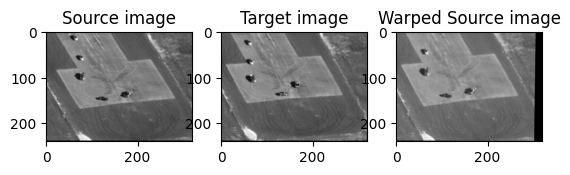

In [37]:
import cv2

num_iters = 100
threshold = 0.01
seq = np.load("data/aerialseq.npy")
It = seq[:,:,0]
It1 = seq[:,:,10]

# Source frame
plt.figure()
plt.subplot(1,3,1)
plt.imshow(It, cmap='gray')
plt.title('Source image')

# Target frame
plt.subplot(1,3,2)
plt.imshow(It1, cmap='gray')
plt.title('Target image')

# Warped source frame
M = LucasKanadeAffine(It, It1, threshold, num_iters)
warped_It = cv2.warpAffine(It, M,(It.shape[1],It.shape[0]))
plt.subplot(1,3,3)
plt.imshow(warped_It, cmap='gray')
plt.title('Warped Source image')
M

# Q3.2: Moving Object Detection (10 points)

In [38]:
import numpy as np
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation
from scipy.ndimage import affine_transform
import scipy.ndimage
import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param num_iters : (int), number of iterations for running the optimization
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: mask    : (H, W), the mask of the moved object
    """
    mask = np.ones(It.shape, dtype=bool)
    
    # Warp the image
    M = LucasKanadeAffine(It, It1, threshold, num_iters)
    warped_img = affine_transform(It, M, output_shape=It.shape)

    # Compute abs difference. If difference is high, this is a movement zone
    diff = np.abs(warped_img - It1)
    mask = diff > tolerance

    # Apply morphological operations for better mask
    _kernel_3X3 = np.ones((3,3), np.uint8)
    _kernel_5X5 = np.ones((5,5), np.uint8)
    mask = binary_dilation(mask,structure= _kernel_5X5, iterations=1)
    mask = binary_erosion(mask, structure= _kernel_3X3, iterations=2)
    return mask


## Q3.3: Tracking with affine motion (10 points)

In [39]:
from tqdm import tqdm

def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param seq       : (H, W, T), sequence of frames
    :param num_iters : int, number of iterations for running the optimization
    :param threshold : float, if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: masks   : (T, 4) moved objects for each frame
    """
    H, W, N = seq.shape
    masks = []
    # Iterate over the car sequence and track the car
    for i in tqdm(range(1, seq.shape[2])):
        frame_0 = seq[:,:,i-1]
        frame_i = seq[:,:,i]
        assert not np.all(frame_0 == frame_i), "The frames are the same"

        mask = SubtractDominantMotion(frame_0, frame_i, num_iters, threshold, tolerance)
        masks.append(mask)

    masks = np.stack(masks, axis=2)
    return masks

## Q3.3 (a) - Track Ant Sequence

In [40]:
seq = np.load("data/antseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1000
threshold = 0.01
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

  0%|          | 0/124 [00:00<?, ?it/s]

100%|██████████| 124/124 [00:18<00:00,  6.71it/s]


Ant Sequence takes 18.500545 seconds


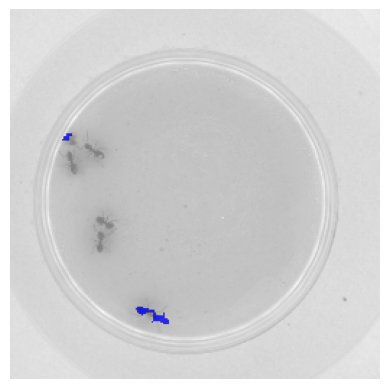

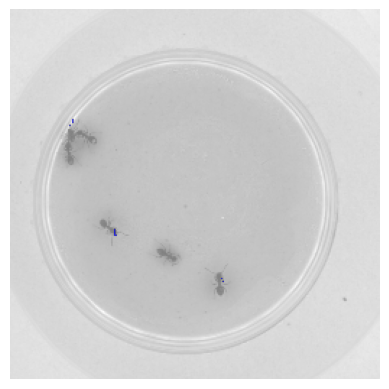

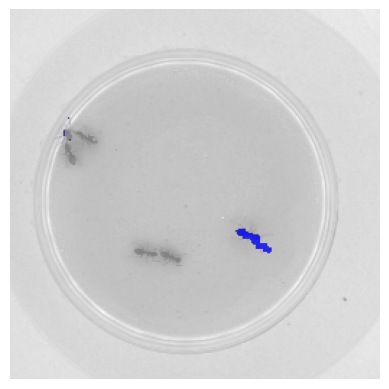

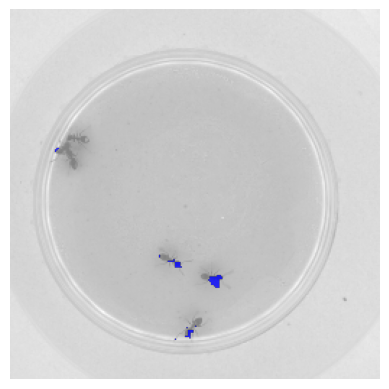

In [41]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')


### Q3.3 (b) - Track Aerial Sequence

In [42]:
seq = np.load("data/aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1000
threshold = 0.01
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAerial Sequence takes %f seconds' % (toc - tic))

100%|██████████| 149/149 [00:45<00:00,  3.26it/s]


Aerial Sequence takes 45.703325 seconds


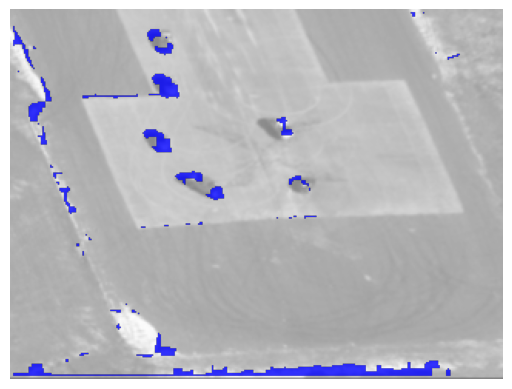

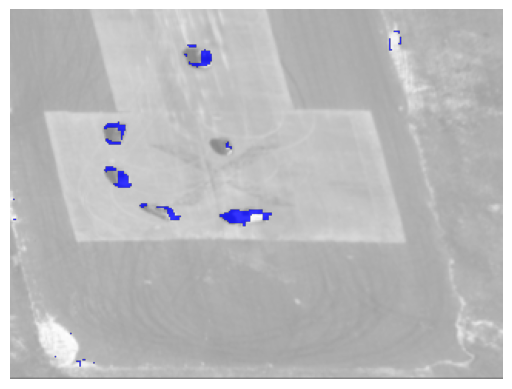

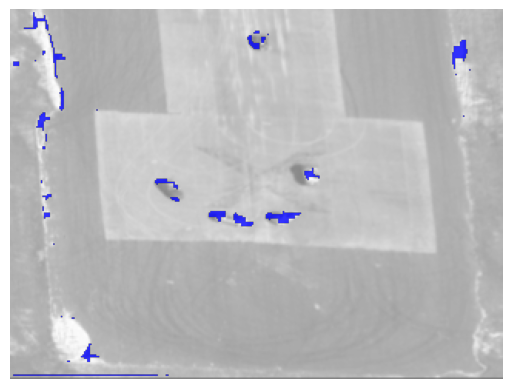

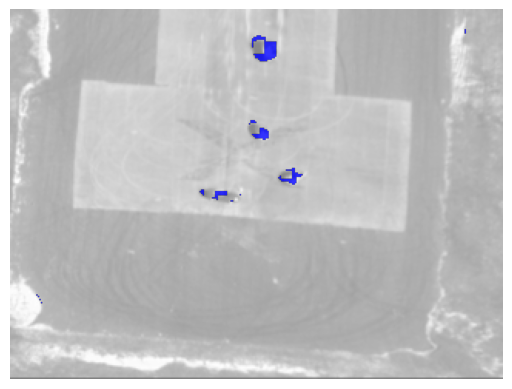

In [43]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')